In [1]:
import numpy as np
from pathlib import Path
import spikeinterface.full as si
import spikeinterface.sorters as ss

import matplotlib.pyplot as plt

from utils import compute_residuals, peak_detection_sweep

In [2]:
%matplotlib widget

In [3]:
session = "1a276285-8b0e-4cc9-9f0a-a3a002978724"
base_folder = Path("/home/alessio/Documents/Data/IBL/BENCHMARKS/")

In [4]:
recording = si.read_cbin_ibl(base_folder / session,
                             stream_name="ap")

In [5]:
recording = recording.frame_slice(0, 60*30000)
recording = recording.channel_slice(recording.channel_ids[:64])

In [6]:
recording

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 1,800,000 samples 
                       60.00s (1.00 minutes) - int16 dtype - 219.73 MiB

### Preprocessing

In [7]:
recording_processed = si.phase_shift(recording)
recording_processed = si.highpass_filter(recording_processed)

In [8]:
bad_channel_ids, bad_channel_labels = si.detect_bad_channels(recording_processed)

In [9]:
# remove bad channels
print(np.unique(bad_channel_labels, return_counts=True))

(array(['good'], dtype='<U5'), array([64]))


In [10]:
recording_clean = recording_processed.remove_channels(bad_channel_ids)

In [11]:
recording_clean = si.common_reference(recording_clean)

In [12]:
print(recording_clean)

CommonReferenceRecording: 64 channels - 30.0kHz - 1 segments - 1,800,000 samples 
                          60.00s (1.00 minutes) - int16 dtype - 219.73 MiB


### Run sorters

In [13]:
si.set_global_job_kwargs(n_jobs=0.5)

In [14]:
ss.installed_sorters()

['kilosort2_5', 'kilosort3', 'mountainsort5', 'spykingcircus2', 'tridesclous2']

In [26]:
sorters = ["spykingcircus2", "mountainsort5", "kilosort2_5", "kilosort3"]
sorting_params = {
    "spykingcircus2": dict(apply_preprocessing=False),
    "mountainsort5": dict(n_jobs_for_preprocessing=4, temporary_base_dir="tmp", filter=False,),
    "kilosort2_5": dict(n_jobs=0.5),
    "kilosort3": dict(n_jobs=0.5),
}

In [27]:
output_folder = Path(".") / session
output_folder.mkdir(exist_ok=True)

In [28]:
tmp_folder = Path("tmp")
tmp_folder.mkdir(exist_ok=True)

overwrite = False

In [29]:
sorting_outputs = dict()
for sorter in sorters:
    if not (output_folder / f"sorting_{sorter}").is_dir() and not overwrite:
        print(f"Running {sorter}")
        sorting = si.run_sorter(sorter_name=sorter, recording=recording_clean,
                                output_folder=output_folder / f"tmp_{sorter}", delete_output_folder=True,
                                remove_existing_folder=True, **sorting_params[sorter])
        sorting = sorting.save(folder=output_folder / f"sorting_{sorter}")
    else:
        print(f"Loading {sorter}")
        sorting = si.load_extractor(output_folder / f"sorting_{sorter}")
    sorting_outputs[sorter] = sorting

Loading spykingcircus2
Loading mountainsort5
Loading kilosort2_5
Running kilosort3


In [46]:
for sorter in sorting_outputs:
    sorting = sorting_outputs[sorter]
    total_spikes = np.sum(list(sorting.count_num_spikes_per_unit().values()))
    print(f"{sorter} found {len(sorting.unit_ids)} ({total_spikes} spikes)")

spykingcircus2 found 40 (52977 spikes)
mountainsort5 found 49 (16176 spikes)
kilosort2_5 found 82 (19240 spikes)
kilosort3 found 78 (32844 spikes)


In [31]:
overwrite = False

In [32]:
residuals = dict()
waveforms = dict()
for sorter, sorting in sorting_outputs.items():
    if not (output_folder / f"waveforms_{sorter}").is_dir() or overwrite:
        we = si.extract_waveforms(recording_clean, sorting, folder=output_folder / f"waveforms_{sorter}",
                                  overwrite=True, return_scaled=False)
    else:
        we = si.load_waveforms(output_folder / f"waveforms_{sorter}")
    residual_with, convolved_with = compute_residuals(we, with_scaling=True)
    residuals[sorter] = dict(
        original=recording_clean,
        residuals=residual_with,
        conv=convolved_with,
    )
    waveforms[sorter] = we

extract waveforms shared_memory multi buffer:   0%|          | 0/60 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/60 [00:00<?, ?it/s]

extract amplitude scalings:   0%|          | 0/60 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/60 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/60 [00:00<?, ?it/s]

extract amplitude scalings:   0%|          | 0/60 [00:00<?, ?it/s]

In [34]:
result_all = dict(
    original=recording_clean
)
for sorter in residuals:
    result_all[sorter] = residuals[sorter]["residuals"]

In [35]:
si.plot_traces(result_all, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Detection analysis

In [36]:
thresholds = np.arange(4, 11)[::-1]

In [37]:
thresholds

array([10,  9,  8,  7,  6,  5,  4])

In [38]:
noise_levels = si.get_noise_levels(recording_clean)

In [47]:
peak_counts = {}
peaks = {}

for sorter in residuals:
    residual_recording = residuals[sorter]["residuals"]
    pc, p = peak_detection_sweep(
        residual_recording,
        thresholds,
        noise_levels=noise_levels
    )
    peak_counts[sorter] = pc
    peaks[sorter] = p

detect peaks with 7 thresholds:   0%|          | 0/60 [00:00<?, ?it/s]

detect peaks with 7 thresholds:   0%|          | 0/60 [00:00<?, ?it/s]

detect peaks with 7 thresholds:   0%|          | 0/60 [00:00<?, ?it/s]

detect peaks with 7 thresholds:   0%|          | 0/60 [00:00<?, ?it/s]

AUC spykingcircus2: 0.4805989583333333
AUC mountainsort5: 0.10013020833333333
AUC kilosort2_5: 0.04049479166666666
AUC kilosort3: 0.19231770833333334


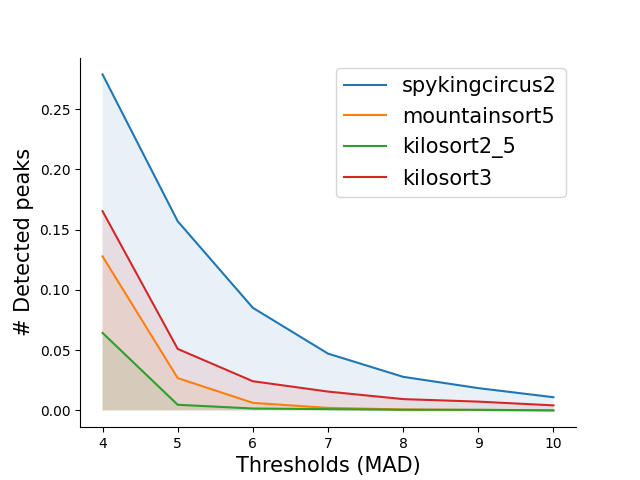

In [48]:
from sklearn.metrics import auc

fig, ax = plt.subplots()

for sorter, pc in peak_counts.items():
    ax.plot(pc.keys(), pc.values(), label=sorter)
    thshs = list(pc.keys())
    counts = list(pc.values())
    auc_val = auc(thshs, counts)
    ax.fill_between(thshs, counts, alpha=0.1)
    print(f"AUC {sorter}: {auc_val}")
ax.legend(fontsize=15)
ax.set_xlabel("Thresholds (MAD)", fontsize=15)
ax.set_ylabel("# Detected peaks", fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
ax.fill_between?

## Identify clear mistakes

In [ ]:
sorter = "mountainsort5"
thresh = 6

In [ ]:
peaks_sorter = peaks[sorter][thresh]
residual_recording = residuals[sorter]["residuals"]

In [ ]:
len(peaks_sorter)

In [ ]:
for peak in peaks_sorter[::5]:
    peak = peaks_sorter[0]

    peak_time = peak["sample_index"] / recording.sampling_frequency
    time_range = [peak_time - 0.005, peak_time + 0.005]

    neighbours = np.arange(peak["channel_index"] - 3, peak["channel_index"] + 3)

    rec_dict = dict(original=recording_clean, residual=residual_recording)
    w = si.plot_traces(rec_dict, mode="line", channel_ids=recording_clean.channel_ids[neighbours],
                       time_range=time_range, show_channel_ids=True)

In [ ]:
templates = we.get_all_templates()

In [ ]:
templates.shape

In [ ]:
templates_unscaled = templates / recording_clean.get_channel_gains()

In [ ]:
templates

In [ ]:
templates_unscaled